<a href="https://colab.research.google.com/github/jungsoo2004/eqsim/blob/master/hands_on_ml_ch3_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np


mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

1


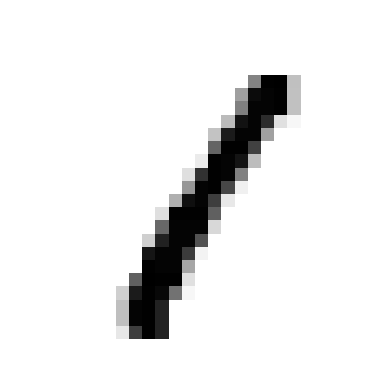

In [2]:
import matplotlib.pyplot as plt

def ordinal_image(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

ordinal_image(X[3])
print(y[3])

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [36]:
'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)    # sparse matrix의 희소성을 깨지 않기 위해
scaled_X_train = scaler.fit_transform(X_train)
'''

In [4]:
unique_labels, counts = np.unique(y_train, return_counts=True)
print(unique_labels)
print(counts)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


train_set이 60000개로 학습 시간이 너무 길어져서 첫 5000개만 이용하여 하이퍼파라미터 튜닝을 진행하려고 함. 모든 label들의 분포가 거의 일정하므로 각 500개씩 추출해서 reduced_train_set 만들기

In [5]:
total_indices = []
for label in unique_labels:
  label_indices = np.where(y_train == label)[0]

  sampled_indices = np.random.choice(label_indices, 500, replace=False)

  for index in sampled_indices:
    total_indices.append(index)

final_indices = np.array(total_indices)
reduced_train_X = X_train[final_indices]
reduced_train_Y = y_train[final_indices]

In [7]:
reduced_train_X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(knn, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(reduced_train_X, reduced_train_Y)
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [8]:
knn_predictor = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_predictor.fit(X_train, y_train)
test_prediction = knn_predictor.predict(X_test)

In [9]:
correct_answer_num = sum(test_prediction == y_test)
accuracy = correct_answer_num / y_test.size
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, test_prediction)
accuracy

0.9717

#2. MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어보세요. 그런 다음 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가하세요. 마지막으로 이 확장된 데이터셋에서 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 측정해보세요. 모델 성능이 더 높아졌는지 확인해보세요!(data augmentation을 진행해보세요)

In [23]:
def move_images(images, direction):
  moved_images = images.copy()
  if direction == 'left':
    for image in moved_images:
      for i in range(len(image)):
        if image[i] > 0:
          image[i-1] = image[i]
          image[i] = 0
  elif direction == 'right':
    for image in moved_images:
      for i in range(len(image)-2, -1, -1):  # 거꾸로 순회
        if image[i] > 0:
          image[i+1] = image[i]
          image[i] = 0
  elif direction == 'up':
    for i in range(1, len(moved_images)):
      image_size = len(moved_images[i])
      for j in range(image_size):
        if moved_images[i][j] > 0:
          moved_images[i-1][j] = moved_images[i][j]
          moved_images[i][j] = 0
  else:  # down
    for i in range(len(moved_images)-2, -1, -1):
      image_size = len(moved_images[i])
      for j in range(image_size):
        if moved_images[i][j] > 0:
          moved_images[i+1][j] = moved_images[i][j]
          moved_images[i][j] = 0

  return np.array(moved_images)



# chatgpt는 numpy의 기능을 이용. 시간 복잡도는 동일하지만 상수 계수에서 큰 차이가 나므로 밑의 코드가 훨씬 빠름. numpy의 벡터화 연산이 굉장히 빠르다는 것을 알고있자.
'''
import numpy as np

def move_images(images, direction):
    images = np.array(images)  # NumPy 배열로 변환
    moved_images = np.zeros_like(images)  # 이동 후 결과를 저장할 배열

    if direction == 'left':
        # 각 행의 값을 한 칸 왼쪽으로 이동
        moved_images[:, :-1] = images[:, 1:]
    elif direction == 'right':
        # 각 행의 값을 한 칸 오른쪽으로 이동
        moved_images[:, 1:] = images[:, :-1]
    elif direction == 'up':
        # 각 열의 값을 한 칸 위로 이동
        moved_images[:-1, :] = images[1:, :]
    elif direction == 'down':
        # 각 열의 값을 한 칸 아래로 이동
        moved_images[1:, :] = images[:-1, :]

    return moved_images
'''

"\nimport numpy as np\n\ndef move_images(images, direction):\n    images = np.array(images)  # NumPy 배열로 변환\n    moved_images = np.zeros_like(images)  # 이동 후 결과를 저장할 배열\n\n    if direction == 'left':\n        # 각 행의 값을 한 칸 왼쪽으로 이동\n        moved_images[:, :-1] = images[:, 1:]\n    elif direction == 'right':\n        # 각 행의 값을 한 칸 오른쪽으로 이동\n        moved_images[:, 1:] = images[:, :-1]\n    elif direction == 'up':\n        # 각 열의 값을 한 칸 위로 이동\n        moved_images[:-1, :] = images[1:, :]\n    elif direction == 'down':\n        # 각 열의 값을 한 칸 아래로 이동\n        moved_images[1:, :] = images[:-1, :]\n\n    return moved_images\n"

In [20]:
augmentated_X_train = []
augmentated_y_train = []

for image in X_train:
  augmentated_X_train.append(image)

for _ in range(5):
  for label in y_train:
    augmentated_y_train.append(label)

left = move_images(X_train, 'left')
for image in left:
  augmentated_X_train.append(image)

right = move_images(X_train, 'right')
for image in right:
  augmentated_X_train.append(image)

up = move_images(X_train, 'up')
for image in up:
  augmentated_X_train.append(image)

down = move_images(X_train, 'down')
for image in down:
  augmentated_X_train.append(image)

In [21]:
augmentated_predictor = KNeighborsClassifier(n_neighbors=3, weights='distance')
augmentated_predictor.fit(np.array(augmentated_X_train), np.array(augmentated_y_train))
test_prediction = augmentated_predictor.predict(X_test)

In [22]:
correct_answer_num = sum(test_prediction == y_test)
accuracy = correct_answer_num / y_test.size
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, test_prediction)
accuracy

0.5978

#3. titanic 데이터셋에 도전해보세요. (https://www.kaggle.com/c/titanic) 데이터를 다운로드하고, 2장의 주택 데이터셋에서 했던 것처럼 압축을 풀면 train.csv, test.csv가 생성됩니다. 이 파일을 pandas.read_csv로 로드할 수 있습니다. 다른 열을 이용하여 survived 열을 예측하는 분류기를 훈련하는 것이 목표입니다